# Interest Rate Prediction

## Case Study

This data belongs to a loan aggregator agency which connects loan applications to different financial institutions in attempt to get the best interest rate. They want to now utilise past data to predict interest rate given by any financial institute just by looking at loan application characteristics.

To achieve that , they have decided to do a POC with a data from a particular financial institution. The data is given in the file "loans data.csv". Lets begin: 

## Step 0: Basic Imports

In [1]:
# this is specific to macos X , windows/linux users dont need this 
# without this , while using xgboost , you get errors , kernel dies
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Step 1: Load dataset

In [4]:
train_file = './data/loan_data_train.csv' #relative path. So in present working directory it will look for data folder.
test_file = './data/loan_data_test.csv'

df_train = pd.read_csv(train_file) #read_csv is a function in pandas.
df_test = pd.read_csv(test_file)               

In [5]:
print(df_train.shape) # check no of rows (ie the no of data points) and cols (ie the no of features)
df_train.head(5) # display the first 5 columns in your dataset

(2200, 15)


,ID,Amount.Requested,Amount.Funded.By.Investors,Interest.Rate,Loan.Length,Loan.Purpose,Debt.To.Income.Ratio,State,Home.Ownership,Monthly.Income,FICO.Range,Open.CREDIT.Lines,Revolving.CREDIT.Balance,Inquiries.in.the.Last.6.Months,Employment.Length
0,79542.0,25000,25000,18.49%,60 months,debt_consolidation,27.56%,VA,MORTGAGE,8606.56,720-724,11,15210,3.0,5 years
1,75473.0,19750,19750,17.27%,60 months,debt_consolidation,13.39%,NY,MORTGAGE,6737.50,710-714,14,19070,3.0,4 years
2,67265.0,2100,2100,14.33%,36 months,major_purchase,3.50%,LA,OWN,1000.00,690-694,13,893,1.0,< 1 year
3,80167.0,28000,28000,16.29%,36 months,credit_card,19.62%,NV,MORTGAGE,7083.33,710-714,12,38194,1.0,10+ years
4,17240.0,24250,17431.82,12.23%,60 months,credit_card,23.79%,OH,MORTGAGE,5833.33,730-734,6,31061,2.0,10+ years


14 features and 1 target variable

In [6]:
#test data does not have interest rate
print(df_test.shape)
df_test.sample(2)

(300, 14)


,ID,Amount.Requested,Amount.Funded.By.Investors,Loan.Length,Loan.Purpose,Debt.To.Income.Ratio,State,Home.Ownership,Monthly.Income,FICO.Range,Open.CREDIT.Lines,Revolving.CREDIT.Balance,Inquiries.in.the.Last.6.Months,Employment.Length
267,67109,4025,4025,36 months,credit_card,15.32%,CA,MORTGAGE,5000.0,700-704,12,15943,0,8 years
260,76810,14000,14000,36 months,credit_card,31.02%,IL,MORTGAGE,5000.0,660-664,15,12728,3,7 years


## Step 2: Manual Feature Engg observations

1. 'Amount.Requested': **convert it to numeric**
2. 'Amount.Funded.By.Investors': **drop**
3. 'Interest.Rate': **remove % and then to numeric**
4. 'Loan.Length': **dummies for categories**
5. 'Loan.Purpose': **dummies for categories**
6. 'Debt.To.Income.Ratio': **remove % and then to numeric**
7. 'State': **dummies for categories**
8. 'Home.Ownership': **dummies for categories**
9. 'FICO.Range': **replace it by a numeric column which is average of the range**
10. 'Open.CREDIT.Lines': **convert it to numeric**
11. 'Revolving.CREDIT.Balance': **convert it to numeric**
12. 'Employment.Length': **convert it to number**


##### Lets group by operation:

1. drop: 
    - ID 
    - Amount.Funded.By.Investors
<br>
2. convert it to numeric 
    - Amount.Requested
    - Open.CREDIT.Lines
    - Revolving.CREDIT.Balance
<br>
3. remove % and then to numeric
    - Interest Rate
    - Debt to income ratio
<br>
4. replace it by a numeric column which is average of the range
    - FICO.Range 
<br>
5. convert to number:
    - Employment Length 
<br>
6. dummies for categories with good occurence rate:
    - Loan Lenth
    - Loan Purpose
    - State
    - Home ownership

In [ ]:
# Manul Feature Engg pipeline for Test dataset

# def preprocessing(dataframe, to_store, std):
    
#     #Operation1
#     dataframe = dataframe.drop(['ID','Amount.Funded.By.Investors'],axis=1)
    
#     #Operation2
#     for col in ['Amount.Requested', 'Open.CREDIT.Lines','Revolving.CREDIT.Balance']:
#         dataframe[col]=pd.to_numeric(dataframe[col],errors='coerce')
    
#     #Operation3
#     for col in ['Debt.To.Income.Ratio']:
#         dataframe[col] = dataframe[col].str.replace("%","") 
    
#     for col in ['Debt.To.Income.Ratio']:
#         dataframe[col]=pd.to_numeric(dataframe[col],errors='coerce') 
    
#     #Operation4
#     k=dataframe['FICO.Range'].str.split("-",expand=True).astype(float)
#     dataframe['fico']=0.5*(k[0]+k[1])
#     del dataframe['FICO.Range']
    
#     #Operation5
#     dataframe['Employment.Length']=dataframe['Employment.Length'].str.replace('years',"")
#     dataframe['Employment.Length']=dataframe['Employment.Length'].str.replace('year',"")
    
#     dataframe['Employment.Length']=np.where(dataframe['Employment.Length'].str[:2]=="10",10,
#                                        dataframe['Employment.Length'])

#     dataframe['Employment.Length']=np.where(dataframe['Employment.Length'].str[0]=="<",0,
#                                        dataframe['Employment.Length'])
    
#     dataframe['Employment.Length']=pd.to_numeric(dataframe['Employment.Length'],errors='coerce')
    
#     #Operation6
#     for column, categories in to_store:
#         for category in categories:
#             name=column+'.'+category
#             dataframe[name]=(dataframe[column]==category).astype(int)
#         del dataframe[column]
    
#     #Missing values
#     imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
#     dataframe = pd.DataFrame(imputer.fit_transform(dataframe), columns=dataframe.columns)
    
#     #data scaling
#     X_test = dataframe.values
#     X_test = std.transform(X_test) #standard scaling
    
#     return X_test

# Feature Engg with Python Pipelines

In [28]:
from mypipes import *

In [ ]:
# Transformers - fit, transform (multiple Transformers)
# Estimator - fit and predict (Single estimator)

In [ ]:
# pipe_name=pdPipeline([
#     ('name of the process',call to process),
#     ('name of the process', call to process),
#     .....
# ])

In [8]:
#Operation2
# for col in ['Amount.Requested', 'Open.CREDIT.Lines','Revolving.CREDIT.Balance']:
#   dataframe[col]=pd.to_numeric(dataframe[col],errors='coerce')

    
p1=pdPipeline([
    ('var_select',VarSelector(['Amount.Requested','Open.CREDIT.Lines','Revolving.CREDIT.Balance'])),
    ('convert_to_numeric',convert_to_numeric()),
    ('missing_trt',DataFrameImputer())
])

In [9]:
#Operation3
# for col in ['Debt.To.Income.Ratio']:
#     dataframe[col] = dataframe[col].str.replace("%","") 

# for col in ['Debt.To.Income.Ratio']:
#     dataframe[col]=pd.to_numeric(dataframe[col],errors='coerce') 
        
p2=pdPipeline([
    ('var_select',VarSelector(['Debt.To.Income.Ratio'])),
    ('string_clean',string_clean(replace_it='%',replace_with='')),
    ('convert_to_numeric',convert_to_numeric()),
    ('missing_trt',DataFrameImputer())
])

In [10]:
#Operation4
# k=dataframe['FICO.Range'].str.split("-",expand=True).astype(float)
# dataframe['fico']=0.5*(k[0]+k[1])
# del dataframe['FICO.Range']
 
p3=pdPipeline([
    ('var_select',VarSelector(['FICO.Range'])),
    ('custom_fico',custom_fico()),
    ('missing_trt',DataFrameImputer())
])

In [11]:
p4=pdPipeline([
    ('var_select',VarSelector(['Monthly.Income','Inquiries.in.the.Last.6.Months'])),
    ('missing_trt',DataFrameImputer())
])

In [12]:
p5=pdPipeline([
    ('var_select',VarSelector(['Loan.Length', 'Loan.Purpose','State','Home.Ownership',
                               'Employment.Length'])),
    ('missing_trt',DataFrameImputer()),
    ('create_dummies',get_dummies_Pipe(20))
])

In [13]:
data_pipe = FeatureUnion([
              ('obj_to_num',p1),
              ('dtir',p2),
              ('fico',p3),
              ('num',p4),
              ('obj_to_dum',p5)
            ])

In [14]:
data_pipe.fit(df_train)

FeatureUnion(transformer_list=[('obj_to_num',
                                pdPipeline(steps=[('var_select',
                                                   VarSelector(feature_names=['Amount.Requested',
                                                                              'Open.CREDIT.Lines',
                                                                              'Revolving.CREDIT.Balance'])),
                                                  ('convert_to_numeric',
                                                   convert_to_numeric()),
                                                  ('missing_trt',
                                                   DataFrameImputer())])),
                               ('dtir',
                                pdPipeline(steps=[('var_select',
                                                   VarSelector(feature_names=['Debt.To.Income.Ratio'])),
                                                  ('...
                             

In [17]:
len(data_pipe.get_feature_names())

60

In [18]:
data_pipe.transform(df_train).shape

(2200, 60)

In [21]:
x_train=pd.DataFrame(data=data_pipe.transform(df_train),
                     columns=data_pipe.get_feature_names())

In [22]:
x_test=pd.DataFrame(data=data_pipe.transform(df_test),
                    columns=data_pipe.get_feature_names())

In [23]:
x_train.shape

(2200, 60)

In [24]:
x_test.shape

(300, 60)

In [25]:
x_train.columns

Index(['obj_to_num__Amount.Requested', 'obj_to_num__Open.CREDIT.Lines',
       'obj_to_num__Revolving.CREDIT.Balance', 'dtir__Debt.To.Income.Ratio',
       'fico__fico', 'num__Monthly.Income',
       'num__Inquiries.in.the.Last.6.Months',
       'obj_to_dum__Loan.Length_36 months',
       'obj_to_dum__Loan.Length_60 months',
       'obj_to_dum__Loan.Purpose_debt_consolidation',
       'obj_to_dum__Loan.Purpose_credit_card',
       'obj_to_dum__Loan.Purpose_other',
       'obj_to_dum__Loan.Purpose_home_improvement',
       'obj_to_dum__Loan.Purpose_major_purchase',
       'obj_to_dum__Loan.Purpose_small_business',
       'obj_to_dum__Loan.Purpose_car', 'obj_to_dum__Loan.Purpose_wedding',
       'obj_to_dum__Loan.Purpose_medical', 'obj_to_dum__Loan.Purpose_moving',
       'obj_to_dum__State_CA', 'obj_to_dum__State_NY', 'obj_to_dum__State_FL',
       'obj_to_dum__State_TX', 'obj_to_dum__State_PA', 'obj_to_dum__State_IL',
       'obj_to_dum__State_GA', 'obj_to_dum__State_NJ', 'obj_to_dum__

In [26]:
x_test.columns

Index(['obj_to_num__Amount.Requested', 'obj_to_num__Open.CREDIT.Lines',
       'obj_to_num__Revolving.CREDIT.Balance', 'dtir__Debt.To.Income.Ratio',
       'fico__fico', 'num__Monthly.Income',
       'num__Inquiries.in.the.Last.6.Months',
       'obj_to_dum__Loan.Length_36 months',
       'obj_to_dum__Loan.Length_60 months',
       'obj_to_dum__Loan.Purpose_debt_consolidation',
       'obj_to_dum__Loan.Purpose_credit_card',
       'obj_to_dum__Loan.Purpose_other',
       'obj_to_dum__Loan.Purpose_home_improvement',
       'obj_to_dum__Loan.Purpose_major_purchase',
       'obj_to_dum__Loan.Purpose_small_business',
       'obj_to_dum__Loan.Purpose_car', 'obj_to_dum__Loan.Purpose_wedding',
       'obj_to_dum__Loan.Purpose_medical', 'obj_to_dum__Loan.Purpose_moving',
       'obj_to_dum__State_CA', 'obj_to_dum__State_NY', 'obj_to_dum__State_FL',
       'obj_to_dum__State_TX', 'obj_to_dum__State_PA', 'obj_to_dum__State_IL',
       'obj_to_dum__State_GA', 'obj_to_dum__State_NJ', 'obj_to_dum__

In [27]:
df_train['Interest.Rate'] = df_train['Interest.Rate'].str.replace("%","") 
df_train['Interest.Rate'] = pd.to_numeric(df_train['Interest.Rate'],errors='coerce') 
y_train = df_train["Interest.Rate"].values

# Permutation Importance

- The idea behind this technique is that feature importance can be measured by looking at how much a desired metric (say accuracy, F1, R^2, etc. - any metric we’re interested in) decreases when a feature is not available.

<br> 

- To do that one can remove feature from the dataset, re-train the estimator and check the score. 
    - But it requires re-training an estimator for each feature, which can be computationally intensive. 
    - Also, it shows what may be important within a dataset, not what is important within a concrete trained model.

<br> 

- To avoid re-training the estimator we can remove a feature only from the test part of the dataset, and compute score without using this feature. 
    - It doesn’t work as-is, because estimators expect feature to be present. 
    - So instead of removing a feature we can replace it with random noise - feature column is still there, but it no longer contains useful information. 
    - This method works if noise is drawn from the same distribution as original feature values (as otherwise estimator may fail). The simplest way to get such noise is to shuffle values for a feature, i.e. use other examples’ feature values - this is how permutation importance is computed.

<br> 

- The method is most suitable for computing feature importances when a number of columns (features) is not huge; it can be resource-intensive otherwise.

## Permuation Importance using rfpimp

In [29]:
from sklearn.ensemble import RandomForestRegressor

In [30]:
# !pip install rfpimp
from rfpimp import *

In [35]:
x_train['random'] = np.random.random(size=len(x_train))

In [38]:
rf = RandomForestRegressor(n_estimators=100,
                            min_samples_leaf=5,
                            n_jobs=-1,
                            oob_score=True)

rf.fit(x_train,y_train)

RandomForestRegressor(min_samples_leaf=5, n_jobs=-1, oob_score=True)

In [39]:
imp = importances(rf, x_train, y_train, n_samples=-1) # this function comes from package rfpimp

In [40]:
imp

,Importance
Feature,
fico__fico,1.194374e+00
obj_to_num__Amount.Requested,2.107850e-01
obj_to_dum__Loan.Length_60 months,1.591265e-01
num__Inquiries.in.the.Last.6.Months,4.719584e-02
obj_to_num__Open.CREDIT.Lines,3.245950e-02
...,...
obj_to_dum__State_WI,0.000000e+00
obj_to_dum__State_SC,0.000000e+00
obj_to_dum__State_NV,0.000000e+00


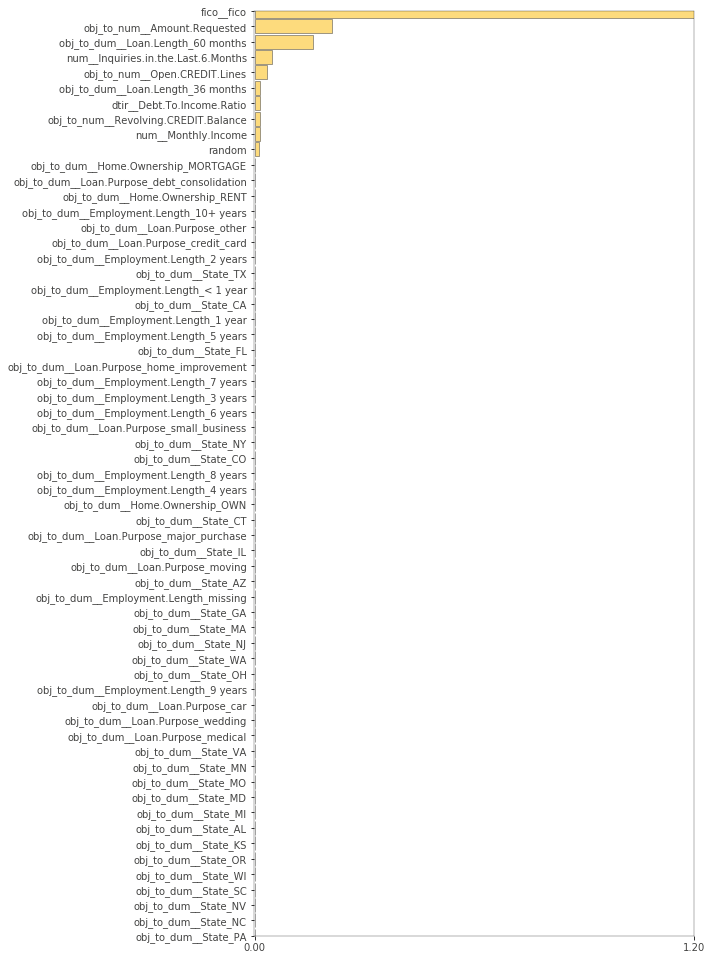

In [41]:
viz = plot_importances(imp, width=10, color='#FDDB7D')
viz.view()

# it is possible that with different iterations of the code result in features at boundary switch to other side
# dont worry about that , they dont make much difference either way [ and you have to draw a line somewhere]

In [42]:
viz.save('interest_rate_featureImp.png')

<Figure size 432x288 with 0 Axes>

# Genetic Algorithm

- A genetic algorithm is an adaptive heuristic search algorithm inspired by "Darwin's theory of evolution in Nature."
- It is used to solve optimization problems in machine learning. It is one of the important algorithms as it helps solve complex problems that would take a long time to solve.

## Terminologies

- Population: Population is the subset of all possible or probable solutions, which can solve the given problem.
- Chromosomes: A chromosome is one of the solutions in the population for the given problem, and the collection of gene generate a chromosome.
- Gene: A chromosome is divided into a different gene, or it is an element of the chromosome.
- Allele: Allele is the value provided to the gene within a particular chromosome.
- Fitness Function: The fitness function is used to determine the individual's fitness level in the population. It means the ability of an individual to compete with other individuals. In every iteration, individuals are evaluated based on their fitness function.
- Genetic Operators: In a genetic algorithm, the best individual mate to regenerate offspring better than parents. Here genetic operators play a role in changing the genetic composition of the next generation.

## Process

- The process of a genetic algorithm starts by generating the set of individuals, which is called population. Here each individual is the solution for the given problem. An individual contains or is characterized by a set of parameters called Genes. Genes are combined into a string and generate chromosomes, which is the solution to the problem. 

<img align="center" src="./images/ga1.png" width="400" height="280" />

- New Chromosome creation by crossover

<img align="center" src="./images/ga2.png" width="800" height="280" />


## Workflow
<img align="center" src="./images/ga3.png" width="200" height="600" />


In [ ]:
df_train

In [ ]:
x_train = df_train[['Amount.Requested','FICO.Range']]

In [ ]:
x_train['Amount.Requested']=pd.to_numeric(x_train['Amount.Requested'],errors='coerce')

In [ ]:
temp = x_train['FICO.Range'].str.split('-',expand=True).astype(int)
x_train['fico']=(temp[0]+temp[1])/2

In [ ]:
del temp
del x_train['FICO.Range']

In [ ]:
for col in x_train:
    x_train[col].fillna(x_train[col].mean(),inplace=True)

In [ ]:
x_train.shape

In [ ]:
y_train.shape

In [ ]:
x_train.describe()

In [ ]:
rf=RandomForestRegressor(n_estimators=150,max_features=2,bootstrap=True)

In [ ]:
rf.fit(x_train,y_train)

In [ ]:
# lets say we want to find out for what value of fico interest rate will be minimum if amount requested 
# is 10000

# for implementing a GA we'll need to implement some version of crossover and mutation 

# we'll sample 10 random values in the range of fico to start with use their average as the value which gives us optimal point 
# a list of 10 [it could be any other number ], will help us in implementing cross over and mutation
amount_requested=5000

In [ ]:
def objective(values):
    
    data=[amount_requested,np.array(values).mean()]
    
    df=pd.DataFrame(data).T
    
    pred=rf.predict(df)[0]
    
    return(pred)

In [ ]:
objective(np.random.randint(1,100,10)) #input = range of fico values, output=interest_rate

In [ ]:
def obj_pop(population):
    scores=[]
    
    for values in population:        
        scores.append([values,objective(values)])
        
    return(scores)

In [ ]:
def select_top_6(population):
    
    scores=obj_pop(population)
#     print(scores)
    scores.sort(key=lambda x:x[1])
#     print(scores)
    selected=scores[:6]
    return(selected)

In [ ]:
def crossover_mutate(parents):
    
    pairs=[(0,5),(1,4),(2,3)]
    
    # this can be made random
    # every pair of parents makes a child , half of child's gene/values
    # come from one parent and rest come from another 
    # then some random values in child are mutated based on some probability threshold 
    # we have taken that to be 0.7
    children=[]
    data=parents.copy()
    
    for i,j in pairs:
        
        rand_ind=np.random.choice(range(10),5,replace=False)
        
        child=parents[i].copy()
        
        for ind in rand_ind:
            
            child[ind]=parents[j][ind]
            
        for ind2 in range(len(child)): # mutation
            
            if np.random.random()>0.7:
                child[ind2]=np.random.randint(500,850,1)
        
        children.append(child)
        
    return(children)
    

In [ ]:
rand_ind=np.random.choice(range(10),5,replace=False)
rand_ind

In [ ]:
# we are starting with totally random values in the range
population=np.random.randint(500,850,size=(10,10))

In [ ]:
population

In [ ]:
num_gen=50

In [ ]:
for _ in range(num_gen):
    
    scored_pop=select_top_6(population)
    
    best_score=scored_pop[0][1]
    
    print(best_score)
    
    parents=[x for x,_ in select_top_6(population)]
    
    # new population will be top 6 parents + 3 children and + 3 random member
    # as the new population evolves , we will reach to best possible outcome
    
    new_population=parents+crossover_mutate(parents)
    
    new_population.extend(np.random.randint(500,850,size=(3,10)))
    
    population=new_population


In [ ]:
best_value=select_top_6(population)[0][0].mean()

In [ ]:
best_value